In [15]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd drive/MyDrive/DeepFake_Detection
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Imports

In [3]:
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, ReLU, ELU, LeakyReLU, Dropout, Dense, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from math import floor, log
from datetime import datetime
import os

In [3]:

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
IMG_WIDTH = 1024

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

# Data

In [5]:
def get_datagen(use_default_augmentation=True, **kwargs):
    kwargs.update({'rescale': 1./255})
    if use_default_augmentation:
        kwargs.update({
            'rotation_range': 15,
            'zoom_range': 0.2,
            'brightness_range': (0.8, 1.2),
            'channel_shift_range': 30,
            'horizontal_flip': True,
        })
    return ImageDataGenerator(**kwargs)

In [6]:
def get_train_data_generator(
    train_data_dir, 
    batch_size, 
    validation_split=None, 
    use_default_augmentation=True,
    augmentations=None
):
    if not augmentations:
        augmentations = {}

    train_datagen = get_datagen(
        use_default_augmentation=use_default_augmentation,
        validation_split=validation_split if validation_split else 0.0,
        **augmentations
    )
   
    train_generator = train_datagen.flow_from_directory(
        directory=train_data_dir,
        target_size=(IMG_WIDTH, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        subset='training',
    )

    validation_generator = None

    if validation_split:
        validation_generator = train_datagen.flow_from_directory(
            directory=train_data_dir,
            target_size=(IMG_WIDTH, IMG_WIDTH),
            batch_size=batch_size,
            class_mode='binary',
            subset='validation'
        )

    return train_generator, validation_generator

In [7]:
def get_test_data_generator(test_data_dir, batch_size, shuffle=False):
    test_datagen = get_datagen(use_default_augmentation=False)
    return test_datagen.flow_from_directory(
        directory=test_data_dir,
        target_size=(IMG_WIDTH, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=shuffle
    )

# Model

In [8]:
def activation_layer(ip, activation, *args):
    return {'relu': ReLU(*args)(ip),
            'elu': ELU(*args)(ip),
            'lrelu': LeakyReLU(*args)(ip)}[activation]

In [9]:
def conv2D(ip,
           filters,
           kernel_size,
           activation,
           padding='same',
           pool_size=(2, 2)):
    layer = Conv2D(filters,
                   kernel_size=kernel_size,
                   padding=padding)(ip)

    layer = activation_layer(layer, activation=activation)

    layer = BatchNormalization()(layer)

    return MaxPooling2D(pool_size=pool_size, padding=padding)(layer)

In [10]:
def fully_connected_layer(ip,
                          hidden_activation,
                          dropout):
    layer = Dense(16)(ip)
    layer = activation_layer(layer, hidden_activation, *[0.1,])
    return Dropout(rate=dropout)(layer)

In [11]:
def build_model(ip=Input(shape=(IMG_WIDTH, IMG_WIDTH, 3)),
                activation='relu',
                dropout=0.5,
                hidden_activation='lrelu'):
    
    layer = conv2D(ip, filters=8, kernel_size=(3, 3), activation=activation)

    layer = conv2D(layer, filters=8, kernel_size=(5, 5), activation=activation)

    layer = conv2D(layer, filters=16, kernel_size=(5, 5), activation=activation)

    layer = conv2D(layer, filters=16, kernel_size=(5, 5), activation=activation, pool_size=(4, 4))

    layer = Flatten()(layer)
    layer = Dropout(rate=dropout)(layer)

    layer = fully_connected_layer(layer, hidden_activation=hidden_activation, dropout=dropout)

    op_layer = Dense(1, activation='sigmoid')(layer)

    model = Model(ip, op_layer)

    return model

In [12]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

def evaluate_model(model, test_data_dir, batch_size):
    data = get_test_data_generator(test_data_dir, batch_size)
    return model.evaluate(data)


def predict(model, data, color, rocLabel="", steps=None, threshold=0.5, nameModel="", fake=False, real=False):
    predictions = model.predict(data, steps=steps, verbose=1)
    
    if fake == False and real == False:
        index_real_one = np.where(data.classes == 1)[0][0]
        predict_fake_images = predictions[:index_real_one]
        predict_real_images = predictions[index_real_one:]
        data_to_save_fake = np.column_stack((data.filenames[:index_real_one], predict_fake_images))
        data_to_save_real = np.column_stack((data.filenames[index_real_one:], predict_real_images))
        np.savetxt(f'predict_fake_images_new_{nameModel}.txt', data_to_save_fake, fmt='%s')
        np.savetxt(f'predict_real_images_new_{nameModel}.txt', data_to_save_real, fmt='%s')
        
        
        # Данные для ROC кривой
        true_labels = np.concatenate((np.zeros(len(predict_fake_images)), np.ones(len(predict_real_images))))
        predicted_probabilities = np.concatenate((predict_fake_images, predict_real_images))

        predicted_labels = (predicted_probabilities > threshold).astype(int)
        cm = confusion_matrix(true_labels, predicted_labels)
        
        real_as_real = cm[0, 0] / (cm[0, 0] + cm[0, 1])
        real_as_fake = cm[0, 1] / (cm[0, 0] + cm[0, 1])
        fake_as_fake = cm[1, 1] / (cm[1, 0] + cm[1, 1])
        fake_as_real = cm[1, 0] / (cm[1, 0] + cm[1, 1])

        print(f"Accuracy (Real as Real): {100 * real_as_real:.2f}%, "
            f"Accuracy (Real as Fake): {100 * real_as_fake:.2f}%, "
            f"Accuracy (Fake as Fake): {100 * fake_as_fake:.2f}%, "
            f"Accuracy (Fake as Real): {100 * fake_as_real:.2f}%")

        # Вычисление ROC кривой и площади под кривой (AUC)
        fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
        roc_auc = roc_auc_score(true_labels, predicted_probabilities)
        print(f'ROC_AUC: {roc_auc}')        
        # Построение ROC кривой
        
        plt.plot(fpr, tpr, color=color, lw=2, label=f'ROC curve {rocLabel} (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color=color, lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        #plt.show()
    
    if fake == True:
        data_to_save_fake = np.column_stack((data.filenames, predictions))
        np.savetxt(f'predict_fake_images_{nameModel}.txt', data_to_save_fake, fmt='%s')

    if real == True:
        data_to_save_real = np.column_stack((data.filenames, predictions))
        np.savetxt(f'predict_real_images_{nameModel}.txt', data_to_save_real, fmt='%s')

    return predictions, np.where(predictions >= threshold, 1, 0)


def save_model_history(history, filename):
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f)

In [13]:
def get_activation_model(model, conv_idx):
    conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
    selected_layers = [layer for index, layer in enumerate(conv_layers) if index in conv_idx]
    activation_model = Model(
        inputs=model.inputs,
        outputs=[layer.output for layer in selected_layers]
    )
    return activation_model

# Visualization

In [14]:
def plot_loss_curve(history):
    plt.plot(history.history['loss'], 'r', label='train')
    plt.plot(history.history['val_loss'], 'g', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [15]:
def get_classification_report(
    model, data_dir, color, rocLabel = "", batch_size=64,
    steps=None, threshold=0.5, output_dict=False, nameModel="", fake=False, real=False
):
    data = get_test_data_generator(data_dir, batch_size=batch_size)
    predictions = predict(model, data, color, rocLabel, steps, threshold, nameModel, fake, real)
    predictions = predictions[1].reshape((predictions[0].shape[0],))
    return classification_report(data.classes, predictions, output_dict=output_dict)

In [16]:
def visualize_conv_layers_single_img(
    activations,
    conv_idx,
):
    images_per_row = 4

    for activation, idx in zip(activations, conv_idx):
        num_filters = activation.shape[-1]

        imgs = [activation[:, :, i] for i in range(num_filters)]

        num_rows = num_filters // images_per_row

        fig = plt.figure()
        grid = ImageGrid(fig, 111, (num_rows, images_per_row))

        for ax, im in zip(grid, imgs):
            ax.imshow(im, cmap='viridis')

        plt.title(f'Convolutional Layer {idx + 1}')
        plt.show()


def visualize_conv_layers(model, imgs, conv_idx):
    activation_model = get_activation_model(model, conv_idx)
    activations = activation_model.predict(imgs)

    num_imgs = imgs.shape[0]
    num_layers = len(conv_idx)

    for idx in range(num_imgs):
        img_activs = [activations[i][idx, :, :, :] for i in range(num_layers)]
        visualize_conv_layers_single_img(
            activations=img_activs, conv_idx=conv_idx
        )

# Training

In [17]:
def train_model(model,
                train_data_dir,
                validation_split=None,
                batch_size=32,
                use_default_augmentation=True,
                augmentations=None,
                epochs=30,
                lr=1e-3,
                loss='binary_crossentropy',
                compile=True,
                lr_decay=True,
                decay_rate=0.10,
                decay_limit=1e-6,
                checkpoint=True,
                stop_early=True,
                monitor='val_accuracy',
                mode='max',
                patience=20,
                tensorboard=True,
                loss_curve=True):
    
    run_time = datetime.now().strftime("%Y%m%d-%H%M%S")

    train_generator, validation_generator = get_train_data_generator(
        train_data_dir=train_data_dir,
        batch_size=batch_size,
        validation_split=validation_split,
        use_default_augmentation=use_default_augmentation,
        augmentations=augmentations
    )

    callbacks = []
    if checkpoint:
        filepath = f'run_{run_time}_best_model_E4E_Older.hdf5'
        model_checkpoint = ModelCheckpoint(
            filepath, monitor='val_accuracy', verbose=1,
            save_best_only=True
        )
        callbacks.append(model_checkpoint)

    if stop_early:
        callbacks.append(
            EarlyStopping(
                monitor=monitor,
                mode=mode,
                patience=patience,
                verbose=1
            )
        )

    if tensorboard:
        log_dir = "logs/fit/" + run_time
        callbacks.append(TensorBoard(log_dir, histogram_freq=1, write_images=True))

    if compile:
        if lr_decay:
            num_times = floor(log(decay_limit / lr, decay_rate))
            per_epoch = epochs // num_times
            lr = ExponentialDecay(
                lr,
                decay_steps=(train_generator.samples // batch_size) * per_epoch,
                decay_rate=decay_rate,
                staircase=True,
            )
        optimizer = Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    history = model.fit(
        train_generator,
        epochs=epochs,
        verbose=1,
        callbacks=callbacks,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=validation_generator.samples // batch_size if validation_generator else None,
    )

    if loss_curve:
        plot_loss_curve(history)

    return history

# Driver (Main)

In [18]:
import scipy

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 1.2124 - accuracy: 0.6812
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to run_20240311-230818_best_model_E4E_Older.hdf5
40/40 [==============================] - 34s 774ms/step - loss: 1.2124 - accuracy: 0.6812 - val_loss: 1.1842 - val_accuracy: 0.5000
Epoch 2/20
40/40 [==============================] - ETA: 0s - loss: 0.5617 - accuracy: 0.8687
Epoch 2: val_accuracy did not improve from 0.50000
40/40 [==============================] - 30s 744ms/step - loss: 0.5617 - accuracy: 0.8687 - val_loss: 1.3099 - val_accuracy: 0.5000
Epoch 3/20
40/40 [==============================] - ETA: 0s - loss: 0.4183 - accuracy: 0.9187
Epoch 3: val_accuracy improved from 0.50000 to 0.67500, saving model to run_20240311-230818_best_model_E4E_Older.hdf5
40/40 [==============================] - 29s 734ms/step - loss: 0.4183 - accuracy: 0.9187

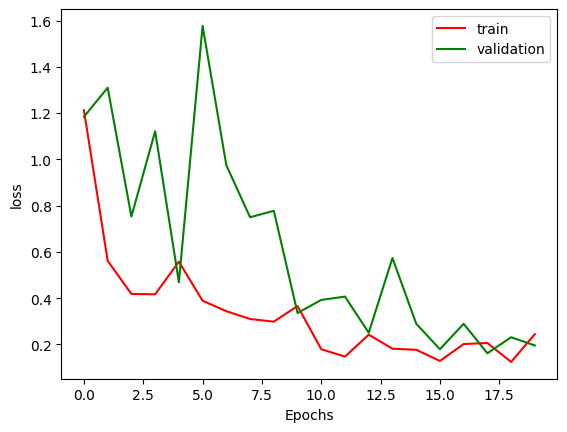

In [19]:
def main(train_data_dir):
    val_split, epochs, batch_size = 0.20, 20, 4
    decay_rate, decay_limit = 0.10, 1e-6
    model = build_model()
    return model, train_model(
        model,
        train_data_dir,
        validation_split=val_split,
        epochs=epochs,
        stop_early=False,
        batch_size = batch_size,
        decay_rate=decay_rate,
        decay_limit=decay_limit,
    )


#model, history = main('D:/DeepFakeRepos/Datasets/RoopData/')
model, history = main('C:\\DatasetD\\E4EOlder_100')
model.save('model_E4E_Older_100_ep20.hdf5')

# Model Evaluation

## 11th Model

In [19]:
# Если модель базовая, то 128
IMG_WIDTH = 1024

baseModelPath = "D:\\DeepFakeRepos\\TestTrainModels\\MESO_BASE_model1_18epochs_valacc0.9252.hdf5"
# roopModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Meso100\\model_MESO_ROOP_100_ep20.hdf5'
# ghostModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Meso100\\model_MESO_GHOST_100_ep20.hdf5'
# olderModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Meso100\\model_MESO_E4E_Older_100_ep20.hdf5'
# smileModelPath = 'D:\\DeepFakeRepos\\TestTrainModels\\Meso100\\model_MESO_E4E_Smile_100_ep20.hdf5'

# # Все выборки по 100
# roopDataPath = "D:\\DeepFakeRepos\\Datasets\\RoopData"
# ghostDataPath = "D:\\DeepFakeRepos\\Datasets\\GhostData"
# olderDataPath = "D:\\DeepFakeRepos\\Datasets\\OlderData"
# smileDataPath = "D:\\DeepFakeRepos\\Datasets\\SmileData"
# faceForensicsPath = "D:\\DeepFakeRepos\\Datasets\\FaceForensics"

# Модели на 1000
roopModelPath = 'D:\\DeepFakeRepos\\ModelFakeDetectQuadro\\Meso1000\\MESO_model_Roop_1000_ep30.hdf5'
ghostModelPath = 'D:\\DeepFakeRepos\\ModelFakeDetectQuadro\\Meso1000\\MESO_model_Ghost_1000_ep30.hdf5'
olderModelPath = 'D:\\DeepFakeRepos\\ModelFakeDetectQuadro\\Meso1000\\MESO_model_Older_1000_ep30.hdf5'
smileModelPath = 'D:\\DeepFakeRepos\\ModelFakeDetectQuadro\\Meso1000\\MESO_model_Smile_1000_ep30.hdf5'

# Все выборки по 100 (не участыующие в обучении даже косвенно)
roopDataPath = "D:\\DeepFakeRepos\\DatasetsUnique\\RoopData"
ghostDataPath = "D:\\DeepFakeRepos\\DatasetsUnique\\GhostData"
olderDataPath = "D:\\DeepFakeRepos\\DatasetsUnique\\OlderData"
smileDataPath = "D:\\DeepFakeRepos\\DatasetsUnique\\SmileData"
faceForensicsPath = "D:\\DeepFakeRepos\\DatasetsUnique\\FaceForensics"

baseDataTestPath = "D:\\DeepFakeRepos\\AllModels\\DeepFakeDetectionModels\\MesoNet-DeepFakeDetection\\data\\test"


BASE_MODEL
BaseData
Found 1945 images belonging to 2 classes.
31/31 [==============================] - 7s 211ms/step
Accuracy (Real as Real): 94.70%, Accuracy (Real as Fake): 5.30%, Accuracy (Fake as Fake): 97.44%, Accuracy (Fake as Real): 2.56%
ROC_AUC: 0.9946487467382522
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       773
           1       0.97      0.97      0.97      1172

    accuracy                           0.96      1945
   macro avg       0.96      0.96      0.96      1945
weighted avg       0.96      0.96      0.96      1945

RoopData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 9s 2s/step
Accuracy (Real as Real): 0.00%, Accuracy (Real as Fake): 100.00%, Accuracy (Fake as Fake): 97.00%, Accuracy (Fake as Real): 3.00%
ROC_AUC: 0.54765
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.49      0.97      0.65

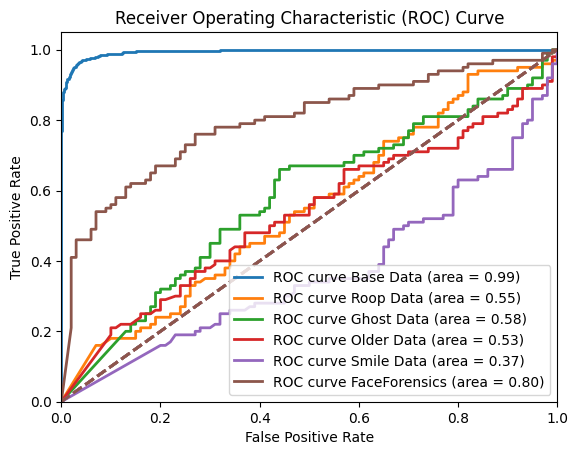

In [21]:
IMG_WIDTH = 256
model_exp = load_model(baseModelPath)

plt.figure()
colors = plt.cm.tab10(np.linspace(0, 1, 10))
print("BASE_MODEL")
print("BaseData")
print(get_classification_report(model_exp, baseDataTestPath,color=colors[0], rocLabel="Base Data", nameModel="BaseData"))

#IMG_WIDTH = 1024
print("RoopData")
print(get_classification_report(model_exp, roopDataPath,color=colors[1], rocLabel="Roop Data", nameModel="BaseData"))

print("GhostData")
print(get_classification_report(model_exp, ghostDataPath,color=colors[2], rocLabel="Ghost Data", nameModel="BaseData"))

print("E4E_OlderData")
print(get_classification_report(model_exp, olderDataPath,color=colors[3], rocLabel="Older Data", nameModel="BaseData"))

print("E4E_SmileData")
print(get_classification_report(model_exp, smileDataPath,color=colors[4], rocLabel="Smile Data", nameModel="BaseData"))

print("FaceForensics")
print(get_classification_report(model_exp, faceForensicsPath,color=colors[5], rocLabel="FaceForensics", nameModel="BaseData"))
plt.show()
#0 - фейк
#1 - реальные

ROOP_MODEL
BaseData
Found 1945 images belonging to 2 classes.
31/31 [==============================] - 73s 2s/step
ROC_AUC: 0.5645461810507353


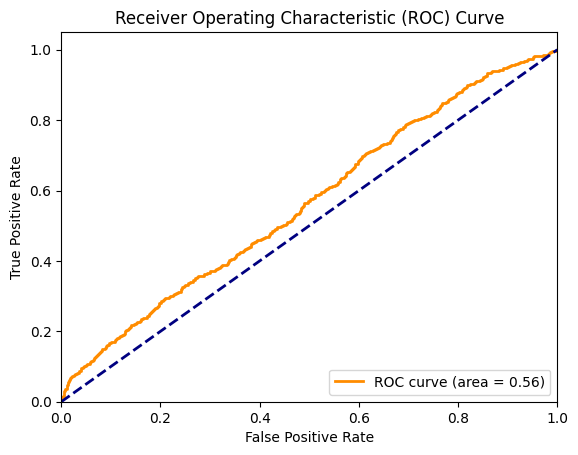

              precision    recall  f1-score   support

           0       0.42      0.89      0.57       773
           1       0.71      0.18      0.28      1172

    accuracy                           0.46      1945
   macro avg       0.56      0.53      0.42      1945
weighted avg       0.59      0.46      0.39      1945

RoopData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 14s 3s/step
ROC_AUC: 0.9667


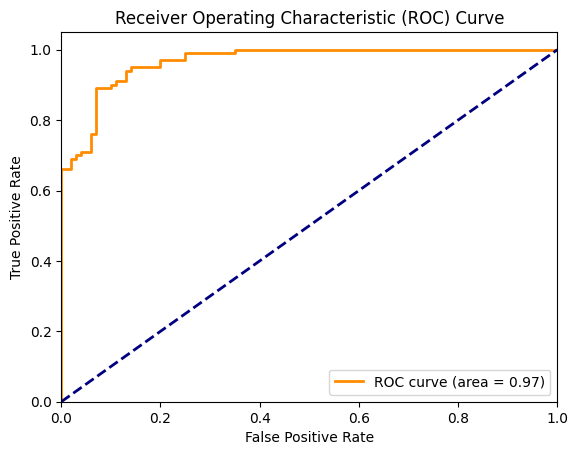

              precision    recall  f1-score   support

           0       0.94      0.84      0.89       100
           1       0.86      0.95      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.90      0.90      0.89       200

GhostData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 14s 3s/step
ROC_AUC: 0.9628000000000001


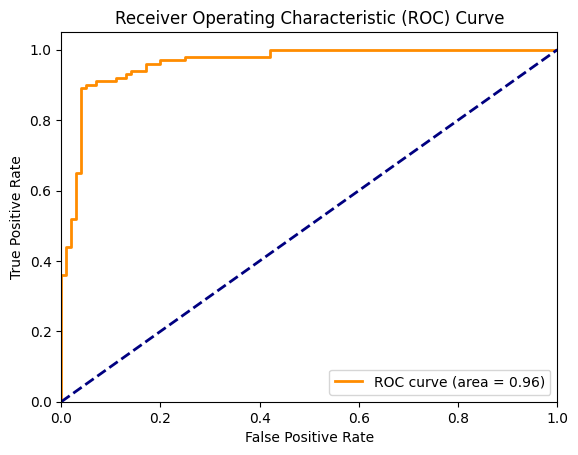

              precision    recall  f1-score   support

           0       0.97      0.67      0.79       100
           1       0.75      0.98      0.85       100

    accuracy                           0.82       200
   macro avg       0.86      0.82      0.82       200
weighted avg       0.86      0.82      0.82       200

E4E_OlderData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 18s 4s/step
ROC_AUC: 0.40645


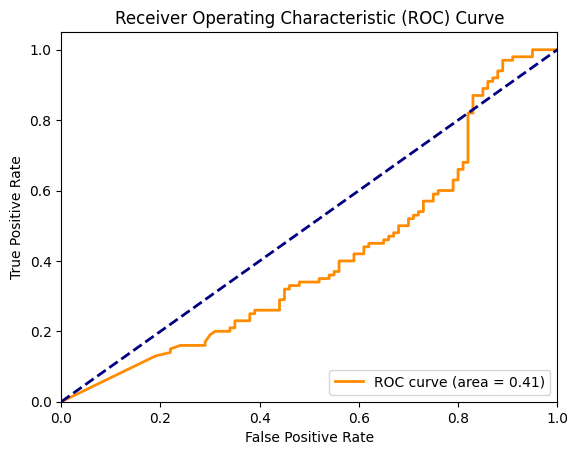

              precision    recall  f1-score   support

           0       0.80      0.08      0.15       100
           1       0.52      0.98      0.68       100

    accuracy                           0.53       200
   macro avg       0.66      0.53      0.41       200
weighted avg       0.66      0.53      0.41       200

E4E_SmileData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 21s 4s/step
ROC_AUC: 0.2507


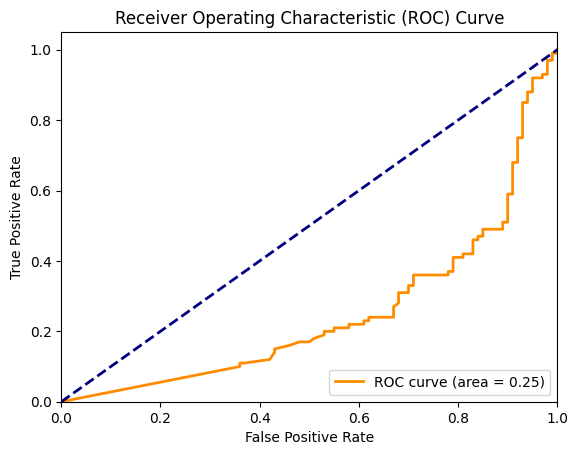

              precision    recall  f1-score   support

           0       0.33      0.01      0.02       100
           1       0.50      0.98      0.66       100

    accuracy                           0.49       200
   macro avg       0.42      0.49      0.34       200
weighted avg       0.42      0.49      0.34       200

FaceForensics
Found 200 images belonging to 2 classes.
4/4 [==============================] - 16s 3s/step
ROC_AUC: 0.9176000000000001


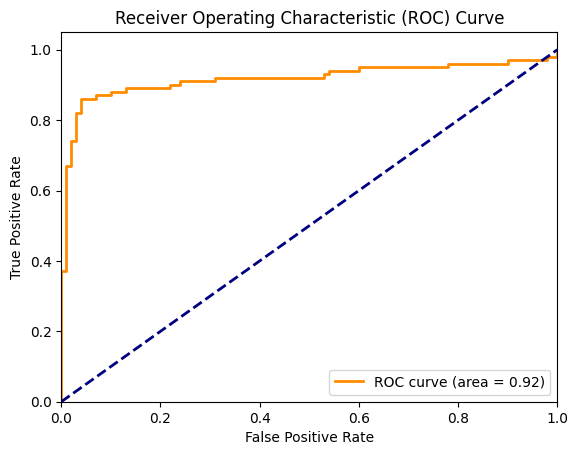

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       100
           1       0.93      0.87      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



In [28]:
IMG_WIDTH = 1024
model_exp = load_model(roopModelPath)

print("ROOP_MODEL")
print("BaseData")
print(get_classification_report(model_exp, baseDataTestPath, nameModel="ROOP"))

print("RoopData")
print(get_classification_report(model_exp, roopDataPath, nameModel="ROOP"))

print("GhostData")
print(get_classification_report(model_exp, ghostDataPath, nameModel="ROOP"))

print("E4E_OlderData")
print(get_classification_report(model_exp, olderDataPath, nameModel="ROOP"))

print("E4E_SmileData")
print(get_classification_report(model_exp, smileDataPath, nameModel="ROOP"))

print("FaceForensics")
print(get_classification_report(model_exp, faceForensicsPath, nameModel="ROOP"))

#0 - фейк
#1 - реальные

GHOST_MODEL_1000
BaseData
Found 1945 images belonging to 2 classes.
31/31 [==============================] - 120s 4s/step
ROC_AUC: 0.501656813355174


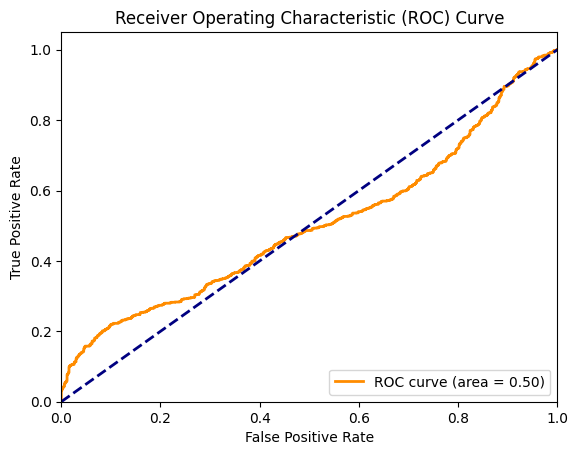

              precision    recall  f1-score   support

           0       0.41      1.00      0.58       773
           1       0.98      0.04      0.07      1172

    accuracy                           0.42      1945
   macro avg       0.69      0.52      0.32      1945
weighted avg       0.75      0.42      0.27      1945

RoopData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 22s 5s/step
ROC_AUC: 0.8876


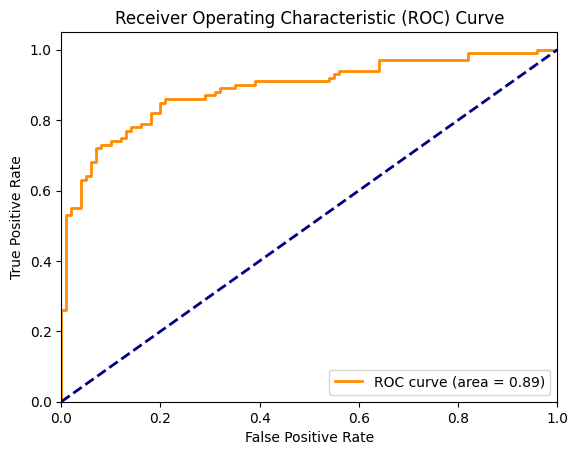

              precision    recall  f1-score   support

           0       0.87      0.65      0.74       100
           1       0.72      0.90      0.80       100

    accuracy                           0.78       200
   macro avg       0.79      0.78      0.77       200
weighted avg       0.79      0.78      0.77       200

GhostData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 22s 5s/step
ROC_AUC: 0.9711000000000001


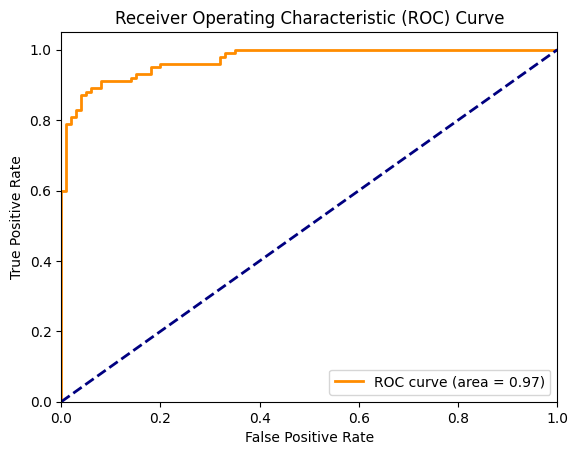

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       100
           1       0.86      0.93      0.89       100

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

E4E_OlderData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 22s 5s/step
ROC_AUC: 0.2982


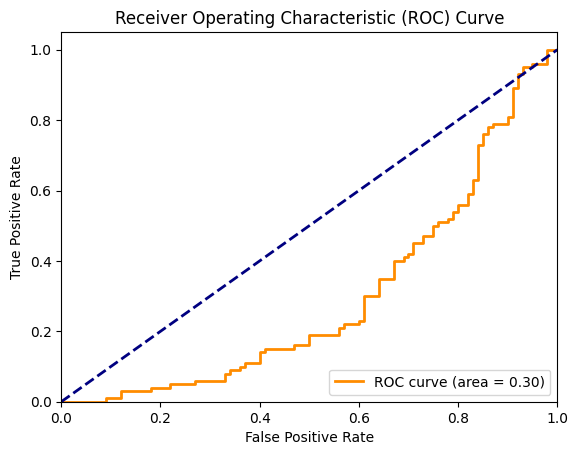

              precision    recall  f1-score   support

           0       0.53      0.08      0.14       100
           1       0.50      0.93      0.65       100

    accuracy                           0.51       200
   macro avg       0.52      0.51      0.40       200
weighted avg       0.52      0.51      0.40       200

E4E_SmileData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 21s 4s/step
ROC_AUC: 0.17420000000000005


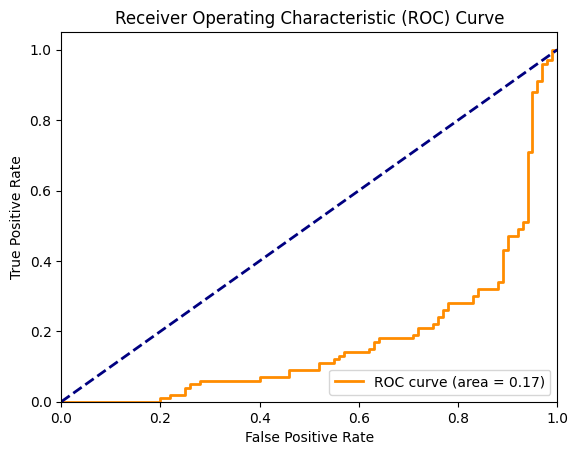

              precision    recall  f1-score   support

           0       0.30      0.03      0.05       100
           1       0.49      0.93      0.64       100

    accuracy                           0.48       200
   macro avg       0.39      0.48      0.35       200
weighted avg       0.39      0.48      0.35       200

FaceForensics
Found 200 images belonging to 2 classes.
4/4 [==============================] - 16s 3s/step
ROC_AUC: 0.9278000000000001


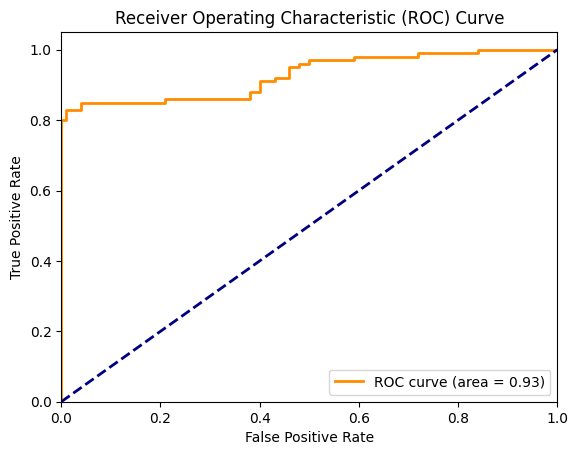

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       100
           1       0.99      0.83      0.90       100

    accuracy                           0.91       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.91      0.91       200



In [27]:
IMG_WIDTH = 1024
model_exp = load_model(ghostModelPath)

print("GHOST_MODEL_1000")
print("BaseData")
print(get_classification_report(model_exp, baseDataTestPath, nameModel="GHOST"))

print("RoopData")
print(get_classification_report(model_exp, roopDataPath, nameModel="GHOST"))

print("GhostData")
print(get_classification_report(model_exp, ghostDataPath, nameModel="GHOST"))

print("E4E_OlderData")
print(get_classification_report(model_exp, olderDataPath, nameModel="GHOST"))

print("E4E_SmileData")
print(get_classification_report(model_exp, smileDataPath, nameModel="GHOST"))

print("FaceForensics")
print(get_classification_report(model_exp, faceForensicsPath, nameModel="GHOST"))

#0 - фейк
#1 - реальные

Older_MODEL_1000
BaseData
Found 1945 images belonging to 2 classes.
31/31 [==============================] - 71s 2s/step
ROC_AUC: 0.618727068422749


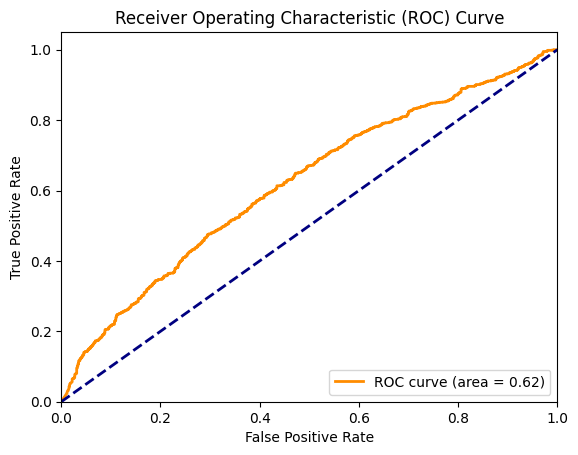

              precision    recall  f1-score   support

           0       0.52      0.16      0.25       773
           1       0.62      0.90      0.73      1172

    accuracy                           0.61      1945
   macro avg       0.57      0.53      0.49      1945
weighted avg       0.58      0.61      0.54      1945

RoopData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 12s 3s/step
ROC_AUC: 0.50075


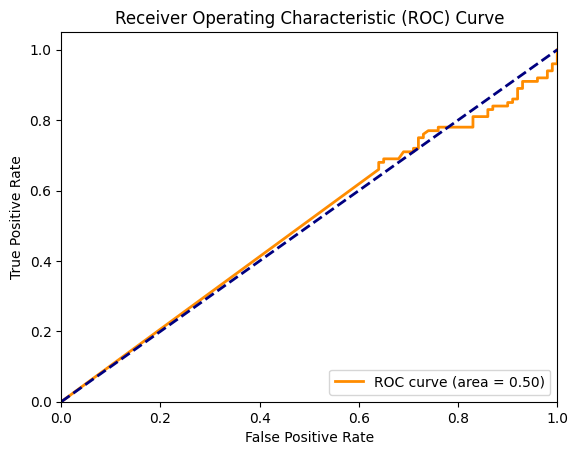

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.49      0.98      0.66       100

    accuracy                           0.49       200
   macro avg       0.25      0.49      0.33       200
weighted avg       0.25      0.49      0.33       200

GhostData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 12s 3s/step
ROC_AUC: 0.5557


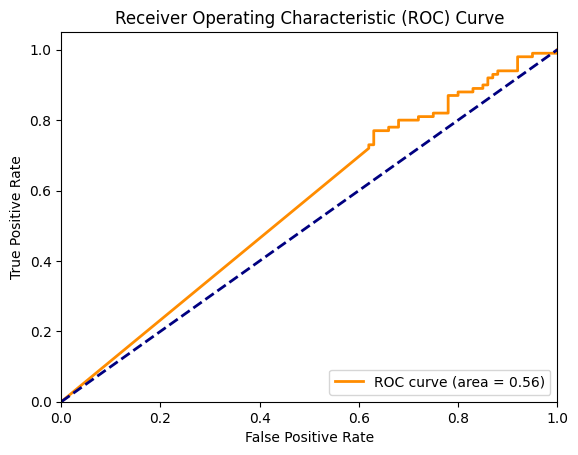

              precision    recall  f1-score   support

           0       0.67      0.02      0.04       100
           1       0.50      0.99      0.67       100

    accuracy                           0.51       200
   macro avg       0.58      0.51      0.35       200
weighted avg       0.58      0.51      0.35       200

E4E_OlderData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 12s 3s/step
ROC_AUC: 0.9991


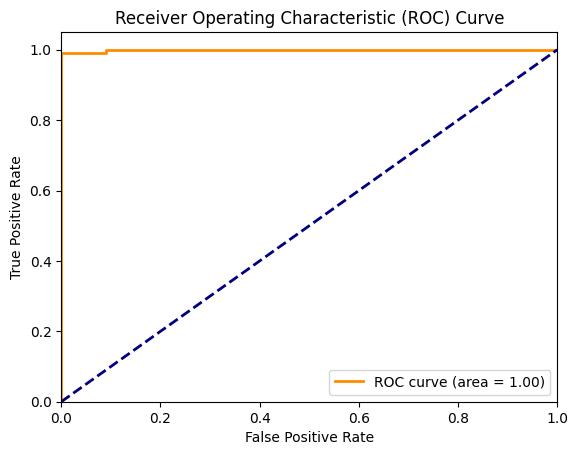

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       100
           1       1.00      0.99      0.99       100

    accuracy                           0.99       200
   macro avg       1.00      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200

E4E_SmileData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 12s 3s/step
ROC_AUC: 0.9871999999999999


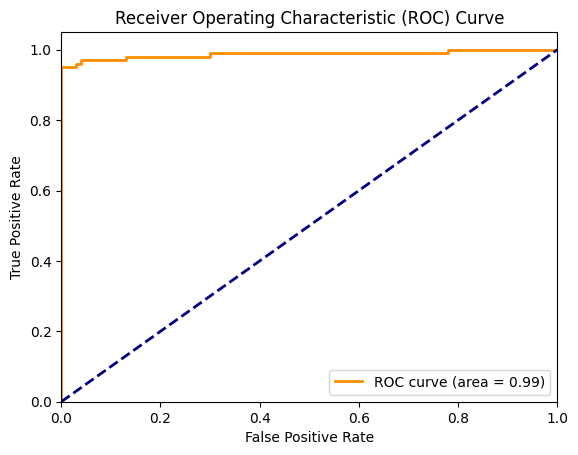

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       100
           1       0.94      0.97      0.96       100

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200

FaceForensics
Found 200 images belonging to 2 classes.
4/4 [==============================] - 9s 2s/step
ROC_AUC: 0.30225


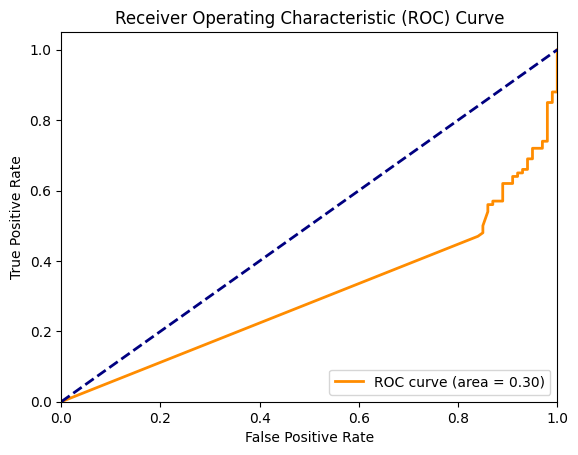

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.48      0.91      0.63       100

    accuracy                           0.46       200
   macro avg       0.24      0.46      0.31       200
weighted avg       0.24      0.46      0.31       200



In [24]:
IMG_WIDTH = 1024

model_exp = load_model(olderModelPath)

print("Older_MODEL_1000")
print("BaseData")
print(get_classification_report(model_exp, baseDataTestPath, nameModel="Older"))

print("RoopData")
print(get_classification_report(model_exp, roopDataPath, nameModel="Older"))

print("GhostData")
print(get_classification_report(model_exp, ghostDataPath, nameModel="Older"))

print("E4E_OlderData")
print(get_classification_report(model_exp, olderDataPath, nameModel="Older"))

print("E4E_SmileData")
print(get_classification_report(model_exp, smileDataPath, nameModel="Older"))

print("FaceForensics")
print(get_classification_report(model_exp, faceForensicsPath, nameModel="Older"))

# OldAgeAttribute

Smile_MODEL
BaseData
Found 1945 images belonging to 2 classes.
31/31 [==============================] - 122s 4s/step
ROC_AUC: 0.6022102618670222


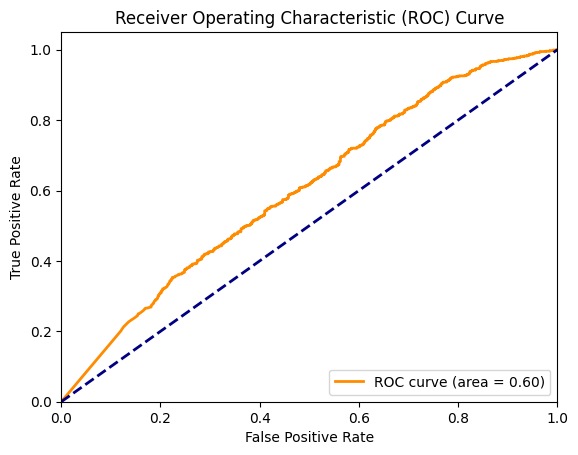

              precision    recall  f1-score   support

           0       0.69      0.15      0.25       773
           1       0.63      0.96      0.76      1172

    accuracy                           0.64      1945
   macro avg       0.66      0.55      0.50      1945
weighted avg       0.66      0.64      0.56      1945

RoopData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 22s 5s/step
ROC_AUC: 0.4898


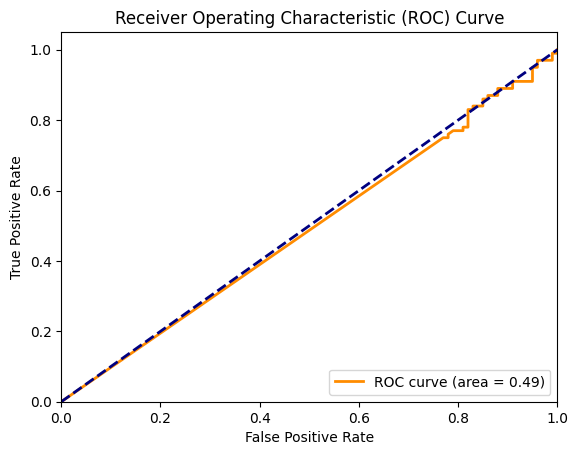

              precision    recall  f1-score   support

           0       0.40      0.02      0.04       100
           1       0.50      0.97      0.66       100

    accuracy                           0.49       200
   macro avg       0.45      0.49      0.35       200
weighted avg       0.45      0.49      0.35       200

GhostData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 22s 5s/step
ROC_AUC: 0.50225


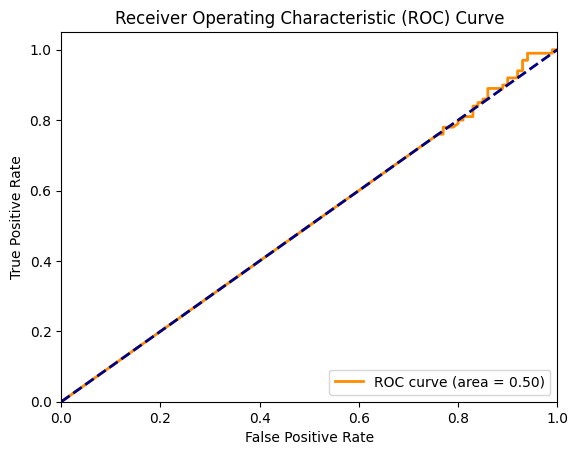

              precision    recall  f1-score   support

           0       0.50      0.01      0.02       100
           1       0.50      0.99      0.66       100

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.34       200
weighted avg       0.50      0.50      0.34       200

E4E_OlderData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 21s 5s/step
ROC_AUC: 0.9989


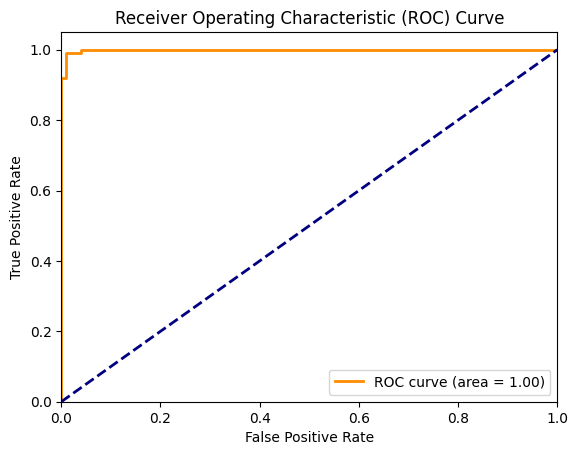

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.98      0.99      0.99       100

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200

E4E_SmileData
Found 200 images belonging to 2 classes.
4/4 [==============================] - 23s 5s/step
ROC_AUC: 1.0


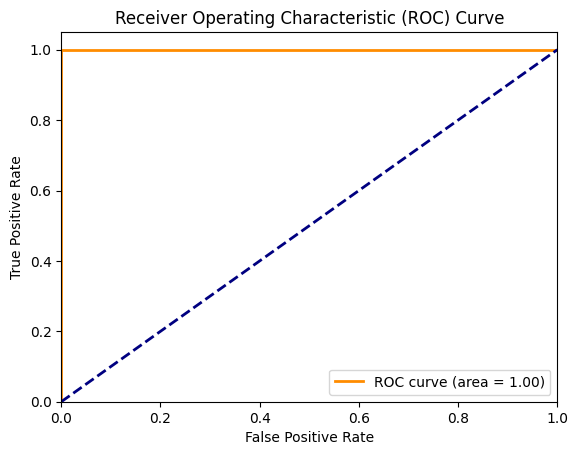

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       100
           1       1.00      0.98      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

FaceForensics
Found 200 images belonging to 2 classes.
4/4 [==============================] - 15s 3s/step
ROC_AUC: 0.37495


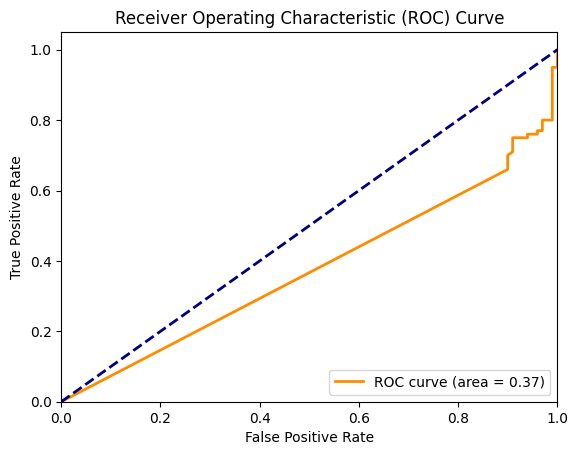

              precision    recall  f1-score   support

           0       0.09      0.01      0.02       100
           1       0.48      0.90      0.62       100

    accuracy                           0.46       200
   macro avg       0.28      0.46      0.32       200
weighted avg       0.28      0.46      0.32       200



In [25]:
IMG_WIDTH = 1024

model_exp = load_model(smileModelPath)

print("Smile_MODEL")
print("BaseData")
print(get_classification_report(model_exp, baseDataTestPath, nameModel="Smile"))

print("RoopData")
print(get_classification_report(model_exp, roopDataPath, nameModel="Smile"))

print("GhostData")
print(get_classification_report(model_exp, ghostDataPath, nameModel="Smile"))

print("E4E_OlderData")
print(get_classification_report(model_exp, olderDataPath, nameModel="Smile"))

print("E4E_SmileData")
print(get_classification_report(model_exp, smileDataPath, nameModel="Smile"))

print("FaceForensics")
print(get_classification_report(model_exp, faceForensicsPath, nameModel="Smile"))
# Smile

GHOST
Found 200 images belonging to 2 classes.
4/4 [==============================] - 6s 1s/step
Predict fake as fake: 49
Predict fake as real: 49
Predict real as real: 51
Predict real as fake: 51
Accuracy (Real as Real): 51.00%, Accuracy (Real as Fake): 49.00%, Accuracy (Fake as Fake): 49.00%, Accuracy (Fake as Real): 51.00%
ROC_AUC: 0.5


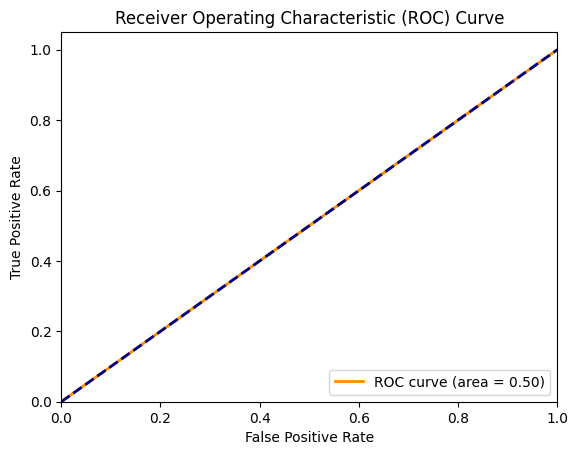

              precision    recall  f1-score   support

           0       0.50      0.51      0.50       100
           1       0.50      0.49      0.49       100

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.50      0.50      0.50       200



In [19]:
compressed_path = "D:\\DeepFakeRepos\\DatasetsCompressed\\"
model_exp = load_model(ghostModelPath)

print("GHOST")
print(get_classification_report(model_exp, compressed_path, nameModel="Ghost"))

GHOST
Found 200 images belonging to 2 classes.
4/4 [==============================] - 8s 2s/step
Predict fake as fake: 94
Predict fake as real: 32
Predict real as real: 68
Predict real as fake: 6
Accuracy (Real as Real): 68.00%, Accuracy (Real as Fake): 32.00%, Accuracy (Fake as Fake): 94.00%, Accuracy (Fake as Real): 6.00%
ROC_AUC: 0.9488


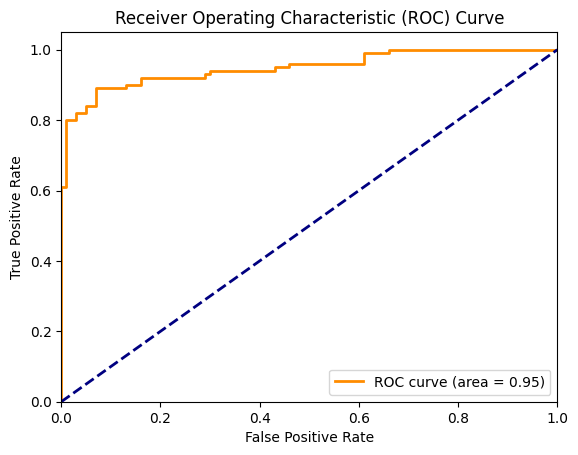

              precision    recall  f1-score   support

           0       0.92      0.68      0.78       100
           1       0.75      0.94      0.83       100

    accuracy                           0.81       200
   macro avg       0.83      0.81      0.81       200
weighted avg       0.83      0.81      0.81       200



In [20]:
compressed_path = "D:\\DeepFakeRepos\\DatasetsGhostFakeCompressed\\"
model_exp = load_model(ghostModelPath)

print("GHOST")
print(get_classification_report(model_exp, compressed_path, nameModel="Ghost"))